# Docker BRATS results

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
import seaborn as sb
import math
import pickle
from pprint import pprint
from nltk import agreement
from sklearn.metrics import cohen_kappa_score
%matplotlib inline

In [33]:
# set up the variables and environment
met = 'wt'
# stupid switch for dumb experiments to make data pretty
stupid = False

#set baseline variables for export and stuff
res = 400 # dpi value for image export
form = 'png' #image format for matplotlib exports
filename = met + '_dice_scores.csv'
#rename colums to their 3 character IDs
candidates = {
        'aju' : 'tumor_istb_aj_class.nii',
        'aca' : 'data_data_prediction.nii.gz',
        'kch' : 'tumor_qtimlab_class.nii.gz',
        'ekr' : 'tumor_00000000_class.nii.gz',
        'aka' : 'tumor_kamleshp_class.nii.gz',
        'mag' : 'tumor_magnrbm_class.nii',
        'sse' : 'tumor_saras_tb_class.nii.gz',
        'rsa': 'tumor_gevaertlab_class.nii',
        'gwa' : 'brats_dc_brats2016_test_klhd_pat101_3.nii.gz',
        'ise' : 'tumor_brats2017_isensee_class.nii.gz',
        'mav' : 'majvote_fusion.nii.gz',
        'sim' : 'simple_fusion.nii.gz',
        'sim2': 'simple2_fusion.nii.gz',
        'none' : 'default'
    }

sseRep = {
    'brats2016_test_cbica_patAMQ_362' : 0,
    'brats2016_test_tcia_pat457_0079' : 0,
    'brats2016_test_cbica_patAOQ1_1' : 0
}
#invert the indices to assign the proper labels
inv_cand = {v: k for k, v in candidates.items()}

irrScores = {}

In [44]:
#import data
data = pandas.read_csv('wt_scores.csv')
#data

In [45]:
#preprocess data
def preprocessor(data, met):
    # remove every 2nd row (unnecessary column heads)
    clean = data.replace({'tumor_saras_tb_class.nii.gz' : sseRep})
    clean = clean.iloc[::2]
    # remove patient name column
    clean = clean.drop('patient', axis=1)
    # rename columns to 3 digit ID
    clean = clean.rename(inv_cand, axis=1)
    # store csv
    #clean.reset_index(inplace=True)
    #print(clean)
    clean.to_csv('test_clean.csv')
    # read a clean copy of the preprocessed csv again
    data = pandas.read_csv('test_clean.csv')
    # remove wrong row indices
    data = data.drop('Unnamed: 0', axis=1)
    return data

In [46]:
data = preprocessor(data, met)
# read a clean copy of the preprocessed csv again
# data = pandas.read_csv(met+'_clean.csv')
# remove wrong row indices
# data = data.drop('Unnamed: 0', axis=1)
data

,gwa,aca,mav,sim2,sim,ekr,ise,rsa,aju,aka,mag,kch,sse
0,0.714753,0.855179,0.715291,0.720879,0.731255,0.728349,0.534961,0.373985,0.718674,0.503754,0.774382,0.566351,0.665399
1,0.804065,0.794520,0.848884,0.849433,0.849433,0.880249,0.870630,0.865455,0.884973,0.830457,0.000081,0.819688,0.793001
2,0.822730,0.843239,0.886360,0.890320,0.890345,0.868159,0.868770,0.862478,0.886347,0.798556,0.760180,0.854587,0.856750
3,0.922985,0.865369,0.931855,0.931029,0.931057,0.926570,0.931202,0.793257,0.927377,0.854902,0.628470,0.905392,0.917223
4,0.583566,0.691135,0.738724,0.738755,0.738755,0.711445,0.745238,0.754293,0.734682,0.695299,0.499353,0.734897,0.632025
5,0.731895,0.781823,0.861866,0.877496,0.876983,0.824909,0.852496,0.573648,0.892955,0.550566,0.850906,0.705489,0.862890
6,0.874818,0.882009,0.903954,0.902717,0.902713,0.898483,0.886490,0.775288,0.864810,0.678067,0.410453,0.840072,0.886252
7,0.908224,0.831214,0.943654,0.945779,0.945735,0.932841,0.945168,0.907449,0.946020,0.879999,0.897950,0.933907,0.921594
8,0.750444,0.660813,0.763147,0.763297,0.762122,0.717341,0.775008,0.706533,0.677683,0.749203,0.342092,0.728119,0.633063
9,0.673709,0.797237,0.773143,0.780907,0.780812,0.725981,0.768690,0.765694,0.777063,0.717665,0.643050,0.582345,0.578904


### Inter Rater Reliability

In [47]:
# IRR function using the Cohen Kappa Score 
# https://en.wikipedia.org/wiki/Cohen%27s_kappa
# create empty dataframe for correlation indices

def irr(data, res, base=5):
    """ Data is the Dataframe with the initial data
    irr is an empty DataFrame with matching columns and indices
    (nxn matrix of n columns) for the resulting scores
    base is the class interval size (default: 5)
    """
    for r1 in data:
        if r1 != 'patient':
            # convert continuous values to integer classes
            rater1 = (data[r1].round(decimals=2)*100).tolist()
            rater1 = list(map(int, rater1))
            rater1 = [base*math.floor(x/base) for x in rater1]
        for r2 in data:
            if r2 != 'patient':
                rater2 = (data[r2].round(decimals=2)*100).tolist()
                rater2 = list(map(int, rater2))
                rater2 = [base*math.floor(x/base) for x in rater2]
                # calculate the cohen kappa score 
                res.loc[r1, r2] = cohen_kappa_score(rater1, rater2)
    # minimal postprocessing before returning
    res = res.astype(float).round(decimals=2)
    return res


rows = list(candidates.keys())
res = pandas.DataFrame(data=None, index=rows, columns=rows)
res.drop(labels=['none', 'sim2'], axis=0, inplace=True)
res.drop(labels=['none', 'sim2'], axis=1, inplace=True)
res = irr(data, res, 5)
export = res.to_latex()
irrScores[met] = res
with open(met + '_irr.txt', 'w') as f: 
    f.write(export)

## Pre- and Postoperative Comparison

In [48]:
preop = data[data['patient'].str.endswith('1', na='nan')]
postop = data.mask(data['patient'].str.endswith('1', na='nan'))
postop = postop.dropna(axis=0)
postop.describe()

KeyError: 'patient'

In [49]:
# IRR for Pre- and Postoperative cases:
# create empty dataframe for correlation indices
res2 = pandas.DataFrame(data=None, index=rows, columns=rows)
temp = irr(preop, res2, base=5)
temp = temp.astype(float).round(decimals=2)
temp.drop(labels=['none', 'sim2', 'patient'], axis=0, inplace=True)
temp.drop(labels=['none', 'sim2'], axis=1, inplace=True)
print(temp)
export = temp.to_latex()
irrScores['preop'] = temp

NameError: name 'preop' is not defined

In [50]:
res3 = pandas.DataFrame(data=None, index=rows, columns=rows)
temp = irr(postop, res3, base=5)
temp = temp.astype(float).round(decimals=2)
temp.drop(labels=['none', 'sim2', 'patient'], axis=0, inplace=True)
temp.drop(labels=['none', 'sim2'], axis=1, inplace=True)
print(temp)
export = temp.to_latex()
irrScores['postop'] = temp

NameError: name 'postop' is not defined

## Dump Data to File 
And reload for testing purposes

In [41]:
# save all data to a pickle file
with open('irr.pkl', 'wb') as f:
        pickle.dump(irrScores, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# load data again
with open('irr.pkl', 'rb') as f:
        scoresReloaded = pickle.load(f)

In [ ]:
#test it
print(scoresReloaded['wt'])

## Postprocessing of Giant Data Dumps from IRR Dice Scoring

In [ ]:
with open('/Users/christoph/Documents/Code/project-kraken/wt_results.pkl', 'rb') as f:
        giantScores = pickle.load(f)

In [ ]:
print('Length:', len(giantScores))

In [ ]:
# rename all columns and indices to the 3-digit ids
# copy scores for backup
scores = giantScores
for k, df in giantScores.items():
    newnames = {
            df.filter(regex='fusion').columns[0]: 'sim',
            df.filter(regex='qtimlab').columns[0]: 'kch',
            df.filter(regex='mikaelagnmagnrbm').columns[0]: 'mag',
            df.filter(regex='ekrivovbrats2017_old').columns[0]: 'ekr',
            df.filter(regex='isensee').columns[0]: 'ise',
            df.filter(regex='brats_dc').columns[0]: 'gwa',
            df.filter(regex='predictionbrats_ac').columns[0]: 'aca',
            df.filter(regex='kamleshpbrats17').columns[0]: 'aka',
            df.filter(regex='gevaertlab').columns[0]: 'rsa'
        }
    try:
        if df.filter(regex='sarassaras_test_brats_2017').columns[0] in df:
            newnames[df.filter(regex='sarassaras_test_brats_2017').columns[0]] = 'sse' 
    except IndexError:
        print('sse not found')
    try:
        if df.filter(regex='istb_aj').columns[0] in df:
            newnames[df.filter(regex='istb_aj').columns[0]] = 'aju'
    except IndexError:
        print('aju not found')
    scores[k] = df.rename(index=newnames, columns=newnames, inplace=False)

# sanity check
len(scores)

In [ ]:
scores['brats2016_test_cbica_patAMO_301']

### Calculate Median and Mean across all Patients

In [ ]:
titles = ['sim', 'aju', 'kch', 'ise', 'ekr', 'mag', 'aca', 'rsa', 'aka', 'gwa', 'sse']
init = np.zeros((11,11))
mean = pandas.DataFrame(data=init, index=titles, columns=titles)
for k, df in scores.items():
    for column in titles:
        for index in titles:
            try:
                mean[column][index] = mean[column][index] + df[column][index]
            except KeyError:
                print('Key error for ', k)

In [ ]:
mean

In [ ]:
result = pandas.DataFrame(data=init, index=titles, columns=titles)
for column in titles:
    for index in titles:
        div = mean[column][column]
        try:
            mean[index][column] = mean[index][column] / div
            if column != index:
                mean[column][index] = mean[column][index] / div
        except KeyError:
            print('Key error for ', k)
mean

In [ ]:
mean.to_csv('irr_export.csv')

In [ ]:
cl_irr = sb.clustermap(mean, method='complete')

### Preop and Postop Data Collection

In [60]:
#comparison of the mean values for pre- and post-operative scans
comp = pandas.concat([preop.mean(), postop.mean(), (postop.mean()- preop.mean()), preop.std(), postop.std()], axis=1, sort=True)
newname = {0:'Preop Mean', 
           1:'Postop Mean',
           2:'Difference',
           3: 'Preop STDEV',
           4: 'Postop STDEV'
          }
comp = comp.rename(columns=newname)
print('Comparison for region ' + met + ': \n', comp)
print('\nMean difference: ' + str(comp['Difference'].mean()))
print('\nMean difference stdev: ' + str(comp['Difference'].std()))
comp = comp.round(decimals=3)*100
tex = comp.to_latex()
with open('textable-'+met+'.txt', 'w') as f: 
    f.write(tex)
prepostplot = sb.boxplot(data=comp['Difference'], width=0.5, palette='spring')
# assemble comprehensive table
if met == 'wt':
    wtcomp = comp.mean()
if met == 'tc':
    tccomp = comp.mean()
if met == 'at':
    atcomp = comp.mean()
    
compressed = pandas.concat([wtcomp, tccomp, atcomp], axis=1, sort=False)
compressed = compressed.rename(columns={0: 'Whole Tumor', 1:'Tumor Core', 2:'Active Tumor'})
compressed = compressed.round(decimals=1)
print(compressed)
tex2 = compressed.to_latex()
with open('textable-complete.txt', 'w') as f: 
    f.write(tex2)

NameError: name 'preop' is not defined

In [51]:
#sort the indices by their mean value and reorder the data frame for descending plotting
m = data.mean()
m_sorted = m.sort_values(ascending=False)
print('Mean values sorted:')
pprint(m_sorted)
print('\nMedian sorted:')
pprint(data.median().sort_values(ascending=False))
print('\nStandard deviation sorted:')
pprint(data.std().sort_values(ascending=True))
indices = m_sorted.keys()
# order dataframe by mean
indices = indices.tolist()
wt_ordered = data[indices]

Mean values sorted:
sim2    0.801316
sim     0.798195
mav     0.797255
aju     0.797011
ise     0.785247
ekr     0.775286
kch     0.765547
aca     0.755070
sse     0.747616
gwa     0.747350
rsa     0.745304
aka     0.708905
mag     0.631775
dtype: float64

Median sorted:
sim2    0.862846
sim     0.861112
ise     0.858494
aju     0.856785
mav     0.855012
ekr     0.844004
kch     0.825068
sse     0.820918
aca     0.813874
rsa     0.813734
gwa     0.811814
aka     0.758393
mag     0.723017
dtype: float64

Standard deviation sorted:
aju     0.169861
sim2    0.176344
sim     0.178141
mav     0.181714
ekr     0.188270
aca     0.195182
kch     0.198085
aka     0.201247
ise     0.201668
gwa     0.212245
rsa     0.215304
sse     0.217502
mag     0.293129
dtype: float64


In [52]:
# export all metrics to a table 
metrics = pandas.concat([m_sorted, data.median(), data.std()], axis=1, sort=True)
newname = {0:'Mean', 
           1:'Median',
           2:'Std-Dev'}
metrics = metrics.rename(columns=newname)
# round the values - who needs 8 decimals for such scores?!
metrics = metrics.round(decimals=3)
metrics.to_csv('tables/'+met+'_table.csv')
metrics = metrics.multiply(100, axis=1)
print(metrics)
exp = metrics.to_latex()
with open('texttable_comparison_top6.txt', 'w') as f: 
    f.write(exp)

      Mean  Median  Std-Dev
aca   75.5    81.4     19.5
aju   79.7    85.7     17.0
aka   70.9    75.8     20.1
ekr   77.5    84.4     18.8
gwa   74.7    81.2     21.2
ise   78.5    85.8     20.2
kch   76.6    82.5     19.8
mag   63.2    72.3     29.3
mav   79.7    85.5     18.2
rsa   74.5    81.4     21.5
sim   79.8    86.1     17.8
sim2  80.1    86.3     17.6
sse   74.8    82.1     21.8


# Fancy Boxplots for DICE Scores

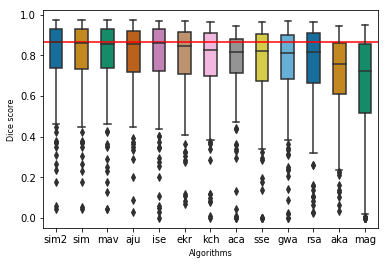

In [56]:
# fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
#wt_ordered.drop(['patient'], axis=1, inplace=True)
bplot = sb.boxplot(data=wt_ordered, 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot.set_xlabel('Algorithms', fontsize=8)
bplot.set_ylabel('Dice score', fontsize=8)
#plot a horizontal line at the max mean location
bplot.hlines(np.max(data.median()), -100, 1000, colors='r')
#save the plot
# bplot.figure.savefig('plots/'+met+'_fullplot.png', format=form, dpi=res)

In [59]:
bplot.figure.savefig('plots/wt_fullplot.png', format=form, dpi=400)

In [ ]:
results = np.split(wt_ordered, [5], axis=1)
bplot1 = sb.boxplot(data=results[0], 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot1.set_xlabel('Algorithms', fontsize=14)
bplot1.set_ylabel('Dice score', fontsize=14)

In [ ]:
bplot2 = sb.boxplot(data=results[1], 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot2.set_xlabel('Algorithms', fontsize=14)
bplot2.set_ylabel('Dice score', fontsize=14)

In [ ]:
#save all of it
#bplot1.figure.savefig(met+'_boxplot1.png', format=form, dpi=res)
#bplot2.figure.savefig(met+'_boxplot2.png', format=form, dpi=res)
#cl.savefig('clustermap.png', format=form, dpi=res)

## Cluster Map

In [ ]:
cl = sb.clustermap(wt_ordered, method='complete')
#cl.savefig('clustermap.png', format=form, dpi=res)

## Compound table for DICE

In [61]:
data = pandas.read_csv('wt_scores.csv')
wt_scores = preprocessor(data, 'whole')
tc_scores = preprocessor(pandas.read_csv('tc_scores.csv'), 'core')
at_scores = preprocessor(pandas.read_csv('at_scores.csv'), 'active')
wt_scores.describe()

,gwa,aca,mav,sim2,sim,ekr,ise,rsa,aju,aka,mag,kch,sse
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.747350,0.755070,0.797255,0.801316,0.798195,0.775286,0.785247,0.745304,0.797011,0.708905,0.631775,0.765547,0.747616
std,0.212245,0.195182,0.181714,0.176344,0.178141,0.188270,0.201668,0.215304,0.169861,0.201247,0.293129,0.198085,0.217502
min,0.000000,0.000000,0.041807,0.044655,0.044550,0.070132,0.000000,0.026506,0.028208,0.034239,0.000000,0.000000,0.000000
25%,0.683905,0.712318,0.735861,0.736549,0.730305,0.706989,0.721377,0.665325,0.717327,0.610079,0.516287,0.697633,0.670978
50%,0.811814,0.813874,0.855012,0.862846,0.861112,0.844004,0.858494,0.813734,0.856785,0.758393,0.723017,0.825068,0.820918
75%,0.897684,0.879584,0.926662,0.928212,0.928205,0.914937,0.927454,0.907231,0.920715,0.862342,0.853878,0.910072,0.902163
max,0.969482,0.941410,0.971710,0.970870,0.970870,0.969949,0.969313,0.962775,0.971800,0.942467,0.950456,0.963775,0.964379


In [65]:
wt_m = wt_scores.mean()
tc_m = tc_scores.mean()
at_m = at_scores.mean()
bobby = pandas.concat([wt_m, tc_m, at_m], axis=1, sort=True)
newkidz = {
    0 : 'WT',
    1 : 'TC',
    2 : 'AT'
}
bobby = bobby.rename(columns=newkidz)
bobby = bobby.round(decimals=3)*100
bobby.to_csv('tables/concisedice.csv')
byebye = bobby.to_latex()
with open('mean_complete.txt', 'w') as f: 
    f.write(byebye)

## Specificity and Sensitivity Plotting

In [19]:
# load data 
wt_spec = preprocessor(pandas.read_csv('specificity/wt_scores.csv'), 'wt-spec')
tc_spec = preprocessor(pandas.read_csv('specificity/tc_scores.csv'), 'tc-spec')
at_spec = preprocessor(pandas.read_csv('specificity/at_scores.csv'), 'at-spec')

wt_sens = preprocessor(pandas.read_csv('sensitivity/wt_scores.csv'), 'wt-sens')
tc_sens = preprocessor(pandas.read_csv('sensitivity/tc_scores.csv'), 'tc-sens')
at_sens = preprocessor(pandas.read_csv('sensitivity/at_scores.csv'), 'at-sens')


In [20]:
wt_spec.describe()

,gwa,aca,mav,sim,ekr,ise,rsa,aju,aka,mag,kch,sse
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.997038,0.998053,0.998021,0.998065,0.997761,0.997765,0.997759,0.997889,0.997894,0.998562,0.997765,0.981581
std,0.002277,0.001433,0.001871,0.001935,0.002152,0.002447,0.002143,0.002310,0.001833,0.001888,0.002067,0.124343
min,0.986896,0.992802,0.986248,0.986317,0.985426,0.985476,0.986896,0.986423,0.987210,0.984556,0.985170,0.000000
25%,0.995881,0.997251,0.997568,0.997614,0.997139,0.997337,0.997195,0.997591,0.997344,0.997892,0.997018,0.996119
50%,0.997508,0.998359,0.998518,0.998649,0.998365,0.998428,0.998332,0.998528,0.998428,0.999009,0.998453,0.997769
75%,0.998599,0.999080,0.999219,0.999276,0.999231,0.999248,0.999169,0.999254,0.999075,0.999658,0.999045,0.998755
max,0.999952,1.000000,0.999952,0.999943,0.999991,1.000000,0.999905,0.999975,0.999702,1.000000,0.999927,1.000000


In [21]:
wt_sens.describe()

,gwa,aca,mav,sim,ekr,ise,rsa,aju,aka,mag,kch,sse
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.925337,0.834989,0.917637,0.917719,0.896970,0.911673,0.868138,0.904699,0.803273,0.629330,0.886006,0.905120
std,0.128110,0.199724,0.115337,0.104760,0.138907,0.154756,0.144047,0.123303,0.169898,0.315894,0.156390,0.183328
min,0.000000,0.000000,0.271318,0.388196,0.067893,0.000000,0.278731,0.193519,0.242386,0.000000,0.000000,0.000000
25%,0.904847,0.818447,0.902589,0.894524,0.884616,0.911771,0.823483,0.884527,0.735611,0.426702,0.859262,0.909420
50%,0.968173,0.893859,0.959317,0.952126,0.946239,0.963720,0.915703,0.950638,0.854056,0.756234,0.944261,0.961321
75%,0.989926,0.942400,0.985975,0.984800,0.971946,0.982543,0.966488,0.976012,0.929386,0.883700,0.981884,0.985540
max,1.000000,0.999346,1.000000,1.000000,1.000000,1.000000,0.999285,0.999397,1.000000,0.988158,1.000000,1.000000


In [22]:
# create Series for mean of specificity and sensitivity
wtsp_m = wt_spec.mean().round(decimals=3)
wtse_m = wt_sens.mean().round(decimals=3)
wtse_m

gwa    0.925
aca    0.835
mav    0.918
sim    0.918
ekr    0.897
ise    0.912
rsa    0.868
aju    0.905
aka    0.803
mag    0.629
kch    0.886
sse    0.905
dtype: float64

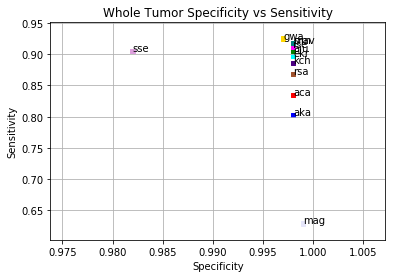

In [23]:
# assemble Series to a single dataframe and rename the columns
wt_plt = pandas.concat([wtsp_m, wtse_m], axis=1, sort=True)
wt_plt = wt_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
# define some colors for the plots
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
# plot sensitivity vs specificity 
ax = wt_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(wt_plt.index):
    ax.annotate(txt, (wt_plt.Specificity.iat[i],wt_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Whole Tumor Specificity vs Sensitivity')
ax.figure.savefig('wt_sesp.png', format=form, dpi=res)
#ax.annotate('aca', wt_plt[0][0], wt_plt[1][0])

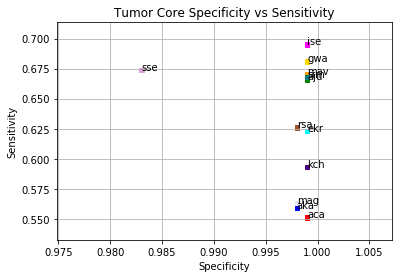

In [24]:
tcsp_m = tc_spec.mean().round(decimals=3)
tcse_m = tc_sens.mean().round(decimals=3)
tc_plt = pandas.concat([tcsp_m, tcse_m], axis=1, sort=True)
tc_plt = tc_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
ax = tc_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(tc_plt.index):
    ax.annotate(txt, (tc_plt.Specificity.iat[i],tc_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Tumor Core Specificity vs Sensitivity')
ax.figure.savefig('tc_sesp.png', format=form, dpi=res)

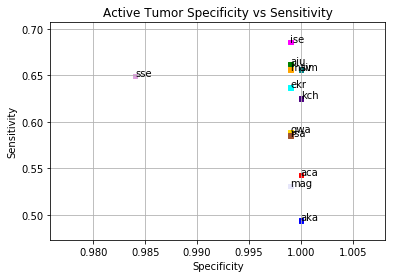

In [25]:
atsp_m = at_spec.mean().round(decimals=3)
atse_m = at_sens.mean().round(decimals=3)
at_plt = pandas.concat([atsp_m, atse_m], axis=1, sort=True)
at_plt = at_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
ax = at_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(at_plt.index):
    ax.annotate(txt, (at_plt.Specificity.iat[i],at_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Active Tumor Specificity vs Sensitivity')
ax.figure.savefig('at_sesp.png', format=form, dpi=res)

Text(0.5, 1.0, 'Active Tumor Specificity vs Sensitivity')

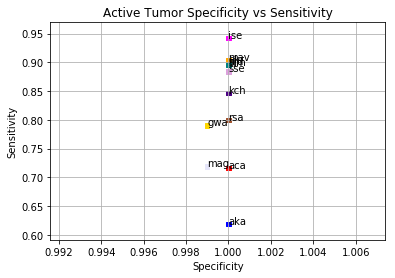

In [26]:
#once again but with MEDIAN 
atsp_m = at_spec.median().round(decimals=3)
atse_m = at_sens.median().round(decimals=3)
at_plt = pandas.concat([atsp_m, atse_m], axis=1, sort=True)
at_plt = at_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
ax = at_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(at_plt.index):
    ax.annotate(txt, (at_plt.Specificity.iat[i],at_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Active Tumor Specificity vs Sensitivity')

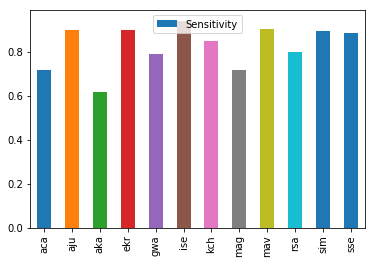

In [27]:
sens = at_plt.plot(y='Sensitivity', kind='bar')